In [1]:
import pandas as pd
import numpy as np

import os
import sys
from IPython.display import Audio


# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)



In [2]:
import kagglehub

# تحميل مجموعة بيانات Ravdess
ravdess_path =  kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to Ravdess dataset files:", ravdess_path)

# تحميل مجموعة بيانات TESS
tess_path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
print("Path to TESS dataset files:", tess_path)

# تحميل مجموعة بيانات CREMA-D
crema_path =  kagglehub.dataset_download("ejlok1/cremad")
print("Path to CREMA-D dataset files:", crema_path)

# تحميل مجموعة بيانات SAVEe
savee_path = kagglehub.dataset_download("barelydedicated/savee-database")
print("Path to SAVEe dataset files:", savee_path)

100%|██████████| 429M/429M [00:05<00:00, 78.5MB/s]

Extracting files...


Path to Ravdess dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


100%|██████████| 428M/428M [00:02<00:00, 163MB/s]

Extracting files...


Path to TESS dataset files: /root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1


100%|██████████| 451M/451M [00:03<00:00, 136MB/s]

Extracting files...


Path to CREMA-D dataset files: /root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1


100%|██████████| 215M/215M [00:02<00:00, 111MB/s]

Extracting files...


Path to SAVEe dataset files: /root/.cache/kagglehub/datasets/barelydedicated/savee-database/versions/1


In [3]:
import os
import shutil

# المسارات التي تم تنزيلها عبر KaggleHub
ravdess_path = '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1'
tess_path = '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1'
cremad_path = '/root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1'
savee_path = '/root/.cache/kagglehub/datasets/barelydedicated/savee-database/versions/1'

# قائمة بالمجلدات لتخزين كل مجموعة بيانات في مجلد خاص بها
datasets = {
    'RAVDESS': ravdess_path,
    'TESS': tess_path,
    'CREMA-D': cremad_path,
    'SAVEe': savee_path
}

# إنشاء مجلدات جديدة لكل مجموعة بيانات داخل /content
for dataset_name, dataset_path in datasets.items():
    # المسار الجديد للمجلد في /content
    new_folder_path = f'/content/{dataset_name}'

    # إذا لم يكن المجلد موجودًا، نقوم بإنشائه
    if not os.path.exists(new_folder_path):
        os.mkdir(new_folder_path)

    # نقل البيانات من المسار الحالي إلى المجلد الجديد
    # ننسخ الملفات والمجلدات إلى المجلد الجديد
    for item in os.listdir(dataset_path):
        source = os.path.join(dataset_path, item)
        destination = os.path.join(new_folder_path, item)

        # نقل الملف أو المجلد
        if os.path.isdir(source):
            shutil.copytree(source, destination)  # إذا كان مجلدًا
        else:
            shutil.copy2(source, destination)  # إذا كان ملفًا

    print(f"Dataset {dataset_name} has been moved to: {new_folder_path}")

# التحقق من محتويات المجلدات الجديدة
for dataset_name in datasets.keys():
    print(f"Contents of {dataset_name}:")
    print(os.listdir(f'/content/{dataset_name}'))


Dataset RAVDESS has been moved to: /content/RAVDESS
Dataset TESS has been moved to: /content/TESS
Dataset CREMA-D has been moved to: /content/CREMA-D
Dataset SAVEe has been moved to: /content/SAVEe
Contents of RAVDESS:
['Actor_04', 'Actor_06', 'Actor_09', 'Actor_12', 'Actor_13', 'Actor_08', 'Actor_16', 'audio_speech_actors_01-24', 'Actor_23', 'Actor_02', 'Actor_18', 'Actor_10', 'Actor_01', 'Actor_15', 'Actor_19', 'Actor_14', 'Actor_21', 'Actor_20', 'Actor_07', 'Actor_17', 'Actor_05', 'Actor_11', 'Actor_03', 'Actor_24', 'Actor_22']
Contents of TESS:
['tess toronto emotional speech set data', 'TESS Toronto emotional speech set data']
Contents of CREMA-D:
['AudioWAV']
Contents of SAVEe:
['AudioData', 'audiodata']


In [4]:
ravdess = "/content/RAVDESS"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)
len(ravdess_directory_list)

['Actor_04', 'Actor_06', 'Actor_09', 'Actor_12', 'Actor_13', 'Actor_08', 'Actor_16', 'audio_speech_actors_01-24', 'Actor_23', 'Actor_02', 'Actor_18', 'Actor_10', 'Actor_01', 'Actor_15', 'Actor_19', 'Actor_14', 'Actor_21', 'Actor_20', 'Actor_07', 'Actor_17', 'Actor_05', 'Actor_11', 'Actor_03', 'Actor_24', 'Actor_22']


25

In [5]:

file_emotion = []
file_path = []

# Get the list of directories in the root directory
ravdess_directory_list = os.listdir(ravdess)

# Loop through each directory in the root directory
for i in ravdess_directory_list:
    # Get the list of items (actors) in the directory
    actor = os.listdir(os.path.join(ravdess, i))

    # Loop through each file in the actor's folder
    for f in actor:
        # Construct the full path to check if it's a file
        full_path = os.path.join(ravdess, i, f)

        # Process only files, skip directories
        if os.path.isfile(full_path):
            # Split the filename based on the expected structure (e.g., "01-01-03-01-01-01-01.wav")
            part = f.split('.')[0].split('-')

            # Check if the file has the expected structure (i.e., at least 3 parts)
            if len(part) > 2:  # Ensure part[2] exists (Emotion)
                # Append emotion (part[2]) and file path to the respective lists
                file_emotion.append(int(part[2]))
                file_path.append(full_path)
            else:
                print(f"Skipping file due to unexpected structure: {f}")

# Optionally print the first few entries to check
print(file_emotion[:10])
print(file_path[:10])

[5, 8, 3, 2, 4, 8, 4, 7, 4, 3]
['/content/RAVDESS/Actor_04/03-01-05-02-02-02-04.wav', '/content/RAVDESS/Actor_04/03-01-08-01-01-01-04.wav', '/content/RAVDESS/Actor_04/03-01-03-01-01-02-04.wav', '/content/RAVDESS/Actor_04/03-01-02-02-01-01-04.wav', '/content/RAVDESS/Actor_04/03-01-04-01-01-02-04.wav', '/content/RAVDESS/Actor_04/03-01-08-02-01-02-04.wav', '/content/RAVDESS/Actor_04/03-01-04-02-02-02-04.wav', '/content/RAVDESS/Actor_04/03-01-07-02-02-02-04.wav', '/content/RAVDESS/Actor_04/03-01-04-02-01-02-04.wav', '/content/RAVDESS/Actor_04/03-01-03-01-02-01-04.wav']


In [6]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral',
                             2:'calm',
                             3:'happy',
                             4:'sad',
                             5:'angry',
                             6:'fear',
                             7:'disgust',
                             8:'surprise'},
                            inplace=True)


print(ravdess_df.Emotions.value_counts())
print("_______________________________________________")
ravdess_df.head()

Emotions
angry       192
surprise    192
happy       192
calm        192
sad         192
disgust     192
fear        192
neutral      96
Name: count, dtype: int64
_______________________________________________


<ipython-input-6-e63ca071e8b1>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral',


,Emotions,Path
0,angry,/content/RAVDESS/Actor_04/03-01-05-02-02-02-04...
1,surprise,/content/RAVDESS/Actor_04/03-01-08-01-01-01-04...
2,happy,/content/RAVDESS/Actor_04/03-01-03-01-01-02-04...
3,calm,/content/RAVDESS/Actor_04/03-01-02-02-01-01-04...
4,sad,/content/RAVDESS/Actor_04/03-01-04-01-01-02-04...


In [7]:
import pandas as pd
from IPython.display import Audio

sad_audio_files = ravdess_df[ravdess_df['Emotions'] == 'surprise']['Path']

sad_audio_file = sad_audio_files.iloc[0]
print(f"Playing sad audio from: {sad_audio_file}")

Audio(sad_audio_file)


Playing sad audio from: /content/RAVDESS/Actor_04/03-01-08-01-01-01-04.wav


<ipython-input-8-8fbf7c37b1f0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotions', data=ravdess_df, order=ravdess_df.Emotions.value_counts().index, palette='viridis', legend=False)


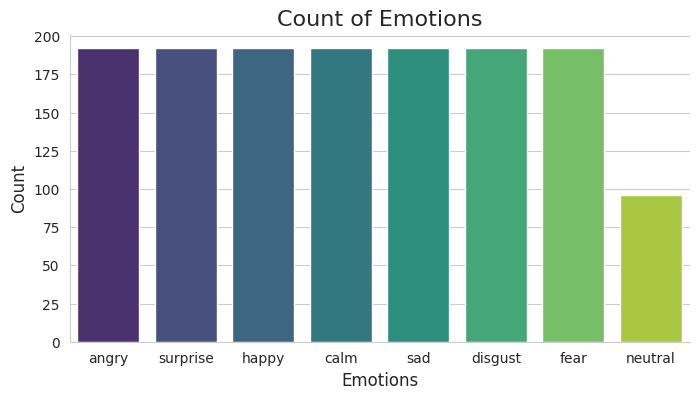

In [8]:
# Set the plot style
sns.set_style('whitegrid')

# Plot the bar chart
plt.figure(figsize=(8, 4))

plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=ravdess_df, order=ravdess_df.Emotions.value_counts().index, palette='viridis', legend=False)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [9]:
y, sr = librosa.load(file_path[0]) # sr = sample rate
print(f'y: {y[50000:50010]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [ 0.10577539  0.03652099  0.02757454  0.1045641   0.1132852   0.03027356
 -0.06523085 -0.11161403 -0.10997246 -0.10875268]
shape y: (84610,)
sr: 22050


In [10]:
Audio(file_path[0], autoplay=True)

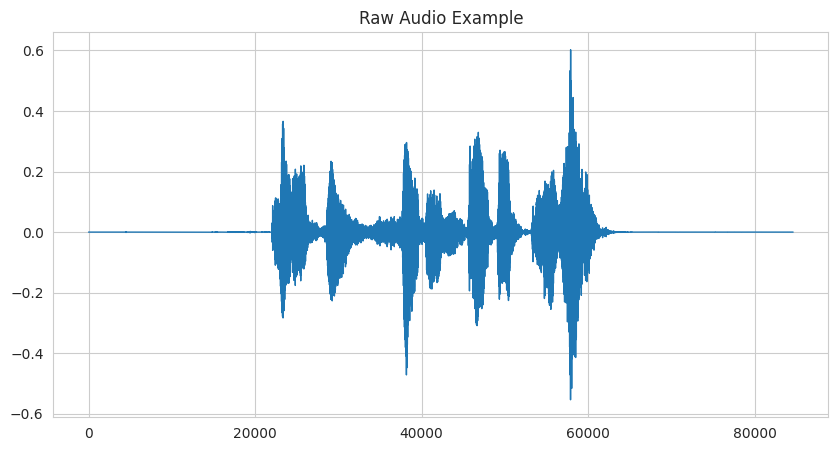

In [11]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example'
                 )
plt.show()

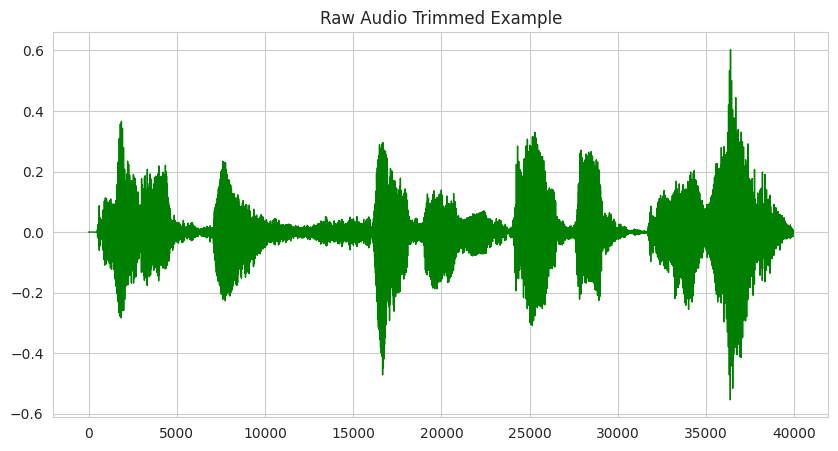

In [12]:
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color='green')
plt.show()

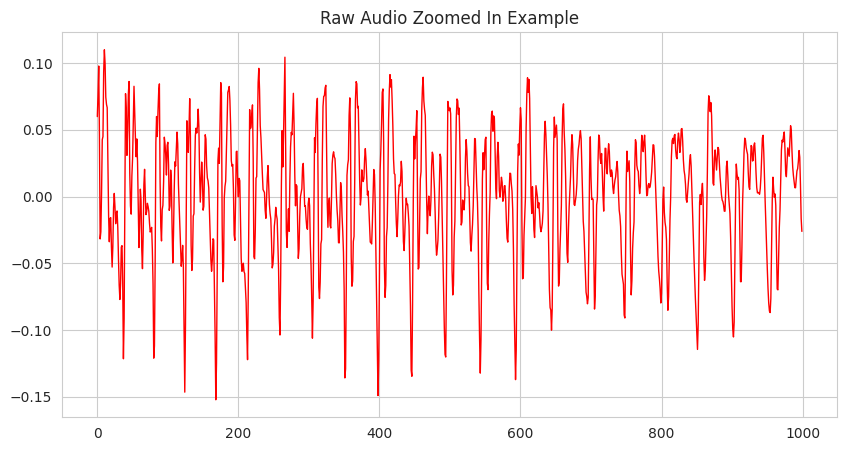

In [13]:
pd.Series(y[30000:31000]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color='red')
plt.show()

In [14]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 166)

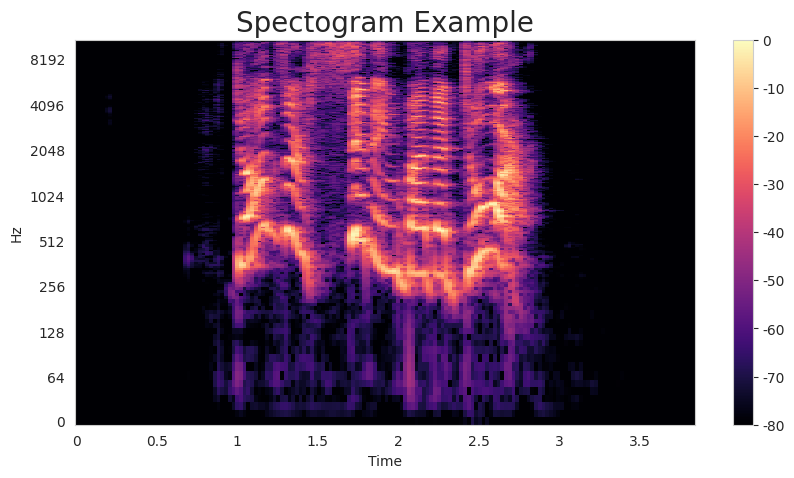

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.0f')
plt.show()

In [16]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,
                                   # fmax=8000,
                                  )
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

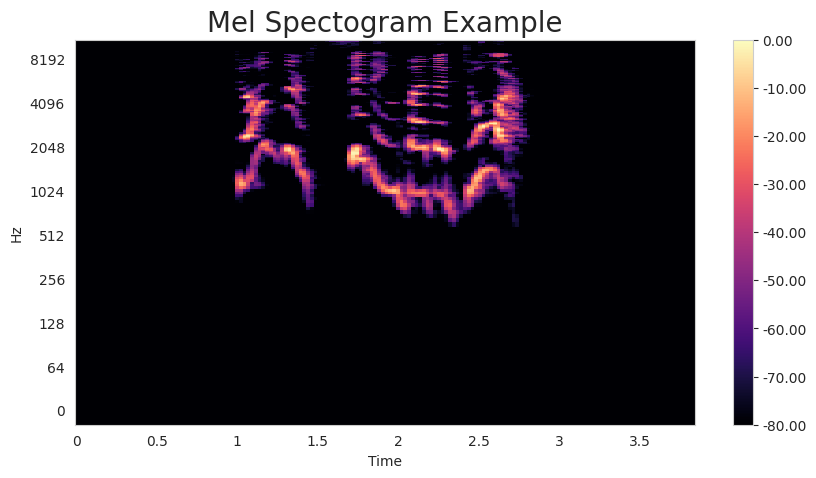

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [33]:
crema_directory_list = os.listdir("/content/CREMA_D/AudioWAV")
CREMA_D="/content/CREMA_D/AudioWAV"

file_emotion = []
file_path = []

for file in crema_directory_list:
    part = file.split('_')
    if len(part) >= 3:
        file_path.append(os.path.join(CREMA_D, file))

        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
    else:
        print(f"Skipping file due to unexpected name structure: {file}")

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
print(Crema_df.head())
print(Crema_df.Emotions.value_counts())

  Emotions                                           Path
0    angry  /content/CREMA_D/AudioWAV/1034_IWW_ANG_XX.wav
1  disgust  /content/CREMA_D/AudioWAV/1069_TSI_DIS_XX.wav
2    happy  /content/CREMA_D/AudioWAV/1021_TIE_HAP_XX.wav
3  disgust  /content/CREMA_D/AudioWAV/1014_TSI_DIS_XX.wav
4     fear  /content/CREMA_D/AudioWAV/1076_MTI_FEA_XX.wav
Emotions
angry      1271
disgust    1271
happy      1271
fear       1271
sad        1271
neutral    1087
Name: count, dtype: int64


In [35]:
import os
import pandas as pd

TESS = "/content/TESS/TESS Toronto emotional speech set data"
tess_directory_list = os.listdir(TESS)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(os.path.join(TESS, dir))
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(os.path.join(TESS, dir, file))

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
print(Tess_df.head())
print(Tess_df.Emotions.value_counts())


  Emotions                                               Path
0  neutral  /content/TESS/TESS Toronto emotional speech se...
1  neutral  /content/TESS/TESS Toronto emotional speech se...
2  neutral  /content/TESS/TESS Toronto emotional speech se...
3  neutral  /content/TESS/TESS Toronto emotional speech se...
4  neutral  /content/TESS/TESS Toronto emotional speech se...
Emotions
neutral     400
sad         400
happy       400
disgust     400
fear        400
angry       400
surprise    400
Name: count, dtype: int64


In [44]:
# # طباعة بعض أسماء الملفات للتحقق من البنية
# for file in savee_directory_list[:10]:  # طباعة أول 10 أسماء فقط
#     print(file)


JK
Info.txt
KL
DC
JE


In [51]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,/content/RAVDESS/Actor_04/03-01-05-02-02-02-04...
1,surprise,/content/RAVDESS/Actor_04/03-01-08-01-01-01-04...
2,happy,/content/RAVDESS/Actor_04/03-01-03-01-01-02-04...
3,calm,/content/RAVDESS/Actor_04/03-01-02-02-01-01-04...
4,sad,/content/RAVDESS/Actor_04/03-01-04-01-01-02-04...


In [52]:
data_path.Emotions.value_counts()

,count
Emotions,
angry,1863
happy,1863
disgust,1863
sad,1863
fear,1863
neutral,1583
surprise,592
calm,192


<ipython-input-53-550df2b24751>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotions', data=data_path, order=data_path.Emotions.value_counts().index, palette='viridis')


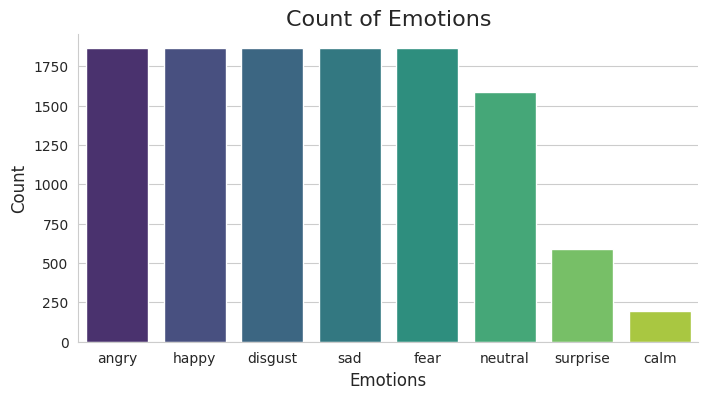

In [53]:
# Set the plot style
sns.set_style('whitegrid')

# Plot the bar chart
plt.figure(figsize=(8, 4))

plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=data_path, order=data_path.Emotions.value_counts().index, palette='viridis')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [63]:
data, sr = librosa.load(data_path.Path.iloc[0])
sr

22050

In [64]:
data

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -5.7153370e-06, -1.1526405e-05,  2.4383585e-06], dtype=float32)

In [67]:
Audio(data_path.Path.iloc[0], autoplay=True)

In [68]:
# PITCH
def pitch(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

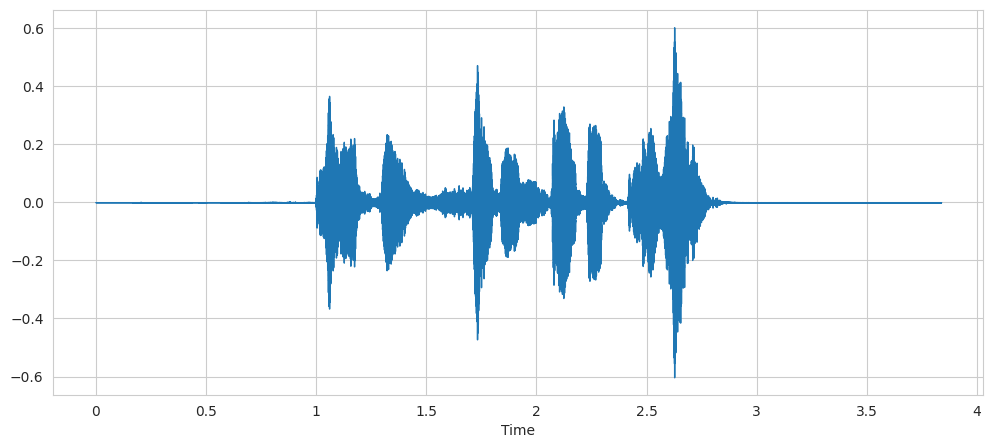

In [69]:
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
Audio(data, rate=sr)

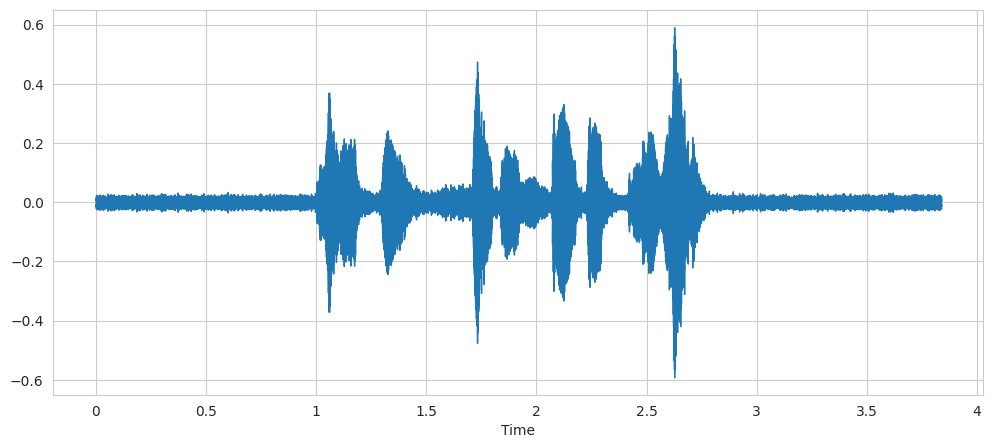

In [70]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sr)

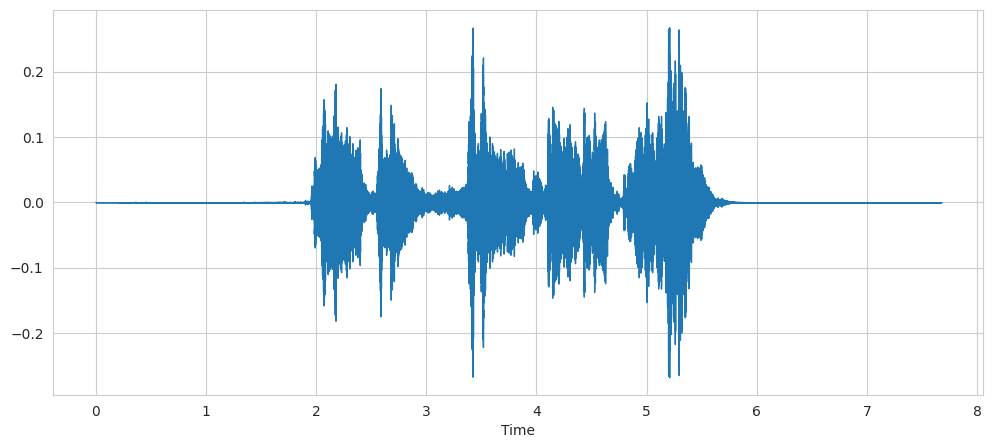

In [71]:
# STRETCHED AUDIO
x = stretch(data, rate=0.5)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sr)

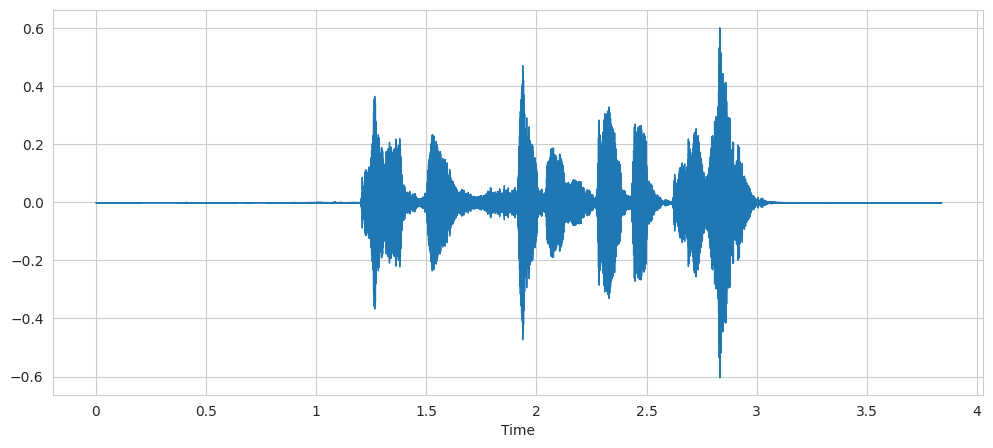

In [72]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sr)

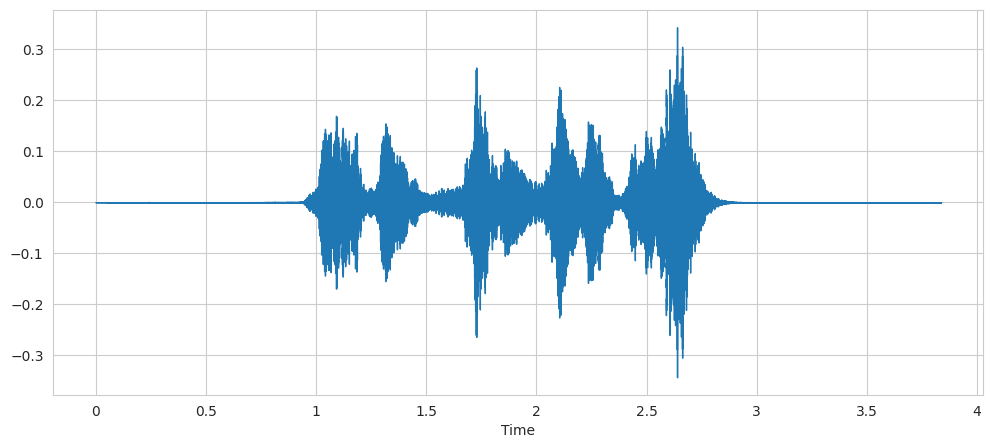

In [73]:
# AUDIO WITH PITCH
x = pitch(data, sr, n_steps=-5)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sr)

In [74]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    # Compute the STFT for features that require it
    stft_data = np.abs(librosa.stft(data, n_fft=frame_length, hop_length=hop_length))

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length).squeeze()

    # Root Mean Square Energy (RMS)
    rmse = librosa.feature.rms(S=stft_data).squeeze()

    # Mel Spectrogram (use y keyword for data)
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)

    # Mel-Frequency Cepstral Coefficients (MFCC)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec), sr=sr, n_mfcc=13).T.ravel()

    # Combine all features into a single array
    return np.hstack([zcr, rmse, mfcc])

def augment_and_extract(data, sr, frame_length=2048, hop_length=512):
    augments = [data, data + 0.005 * np.random.normal(0, 1, len(data)),  # Original + noise
                librosa.effects.pitch_shift(data, sr=sr, n_steps=2),      # Pitched
                librosa.effects.pitch_shift(data + 0.005 * np.random.normal(0, 1, len(data)), sr=sr, n_steps=2)]  # Pitched + noise
    return np.vstack([extract_features(aug, sr, frame_length, hop_length) for aug in augments])

def get_features(path, duration=2.5, offset=0.6, sr=22050, frame_length=2048, hop_length=512):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    return augment_and_extract(data, sr, frame_length, hop_length)

In [75]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


In [76]:
from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()
# Define a function to get features for a single audio file
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  1020.5027632229994


In [1]:
len(X), len(Y), data_path.Path.shape

NameError: name 'X' is not defined

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

In [ ]:
print(Emotions.isna().sum())

In [ ]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().sum().sum())

In [ ]:
#taking last col for Y, which include the emotions
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
x_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [ ]:
model = tf.keras.Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(8, activation='softmax')  # 7 for number of emotion classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=128)

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [ ]:
# Save the trained model
model.save('emotion_recognition_model.h5')

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('emotion_recognition_model.h5')